<a href="https://colab.research.google.com/github/abbasmammadov/Facial-Expression-Recognition/blob/main/Models/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount your drive first - you can do it once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [ ]:
#hyperparameters start form 
lr = 1e-3
batch_size = 32
epochs = 50

#device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU available')
else:
  print('training is done on CPU')

training is done on CPU


In [ ]:
#now let's load the dataset into the 'dataloader' package of pytorch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
#first step is creating an augmentation cell using transforms of pytorch
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-10, +10)),
                        T.RandomAffine(degrees=(-10, +10), translate=(0.1, 0.2)),
                        T.ToTensor()])

valid_augs = T.Compose([T.ToTensor()])

test_augs = T.Compose([T.ToTensor()])

In [ ]:
data_path = '/content/drive/MyDrive/ML_Project_Folder/project/datasets/fer2013'
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test')

In [ ]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
testset = ImageFolder(test_path, transform=test_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")
print(f"Total no. of examples in testset : {len(testset)}")

Total no. of examples in trainset : 28709
Total no. of examples in validset : 3589
Total no. of examples in testset : 3589


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


chosen index:  25351


Text(0.5, 1.0, '5')

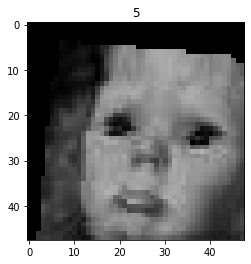

In [ ]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [ ]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)
testloader = DataLoader(testset)
print('total batches in trainloader: ', len(trainloader), ', validloader: ', len(validloader), ', and testloader', len(testloader))

total batches in trainloader:  898 , validloader:  113 , and testloader 3589


In [ ]:
#checking the shapes of each batch
for images, labels in trainloader:
  break
print(f'shape of a batch of images: {images.shape}')
print(f'shape of a batch of labels: {labels.shape}')

shape of a batch of images: torch.Size([32, 3, 48, 48])
shape of a batch of labels: torch.Size([32])


In [ ]:
from torchvision import models

In [ ]:
model = models.vgg19(pretrained=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#accuracy of the model
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
#building the train and eval functions (training the model on the training and on the validation set)
def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def test_model(model, dataloader, current_epoch=1):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TEST]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [ ]:
#now let's train the model
from torch import optim
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True) # gives much better accuracy

In [ ]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/50: 100%|██████████| 113/113 [15:16<00:00,  8.11s/it, loss=1.51, acc=0.422]


SAVED BEST WEIGHTS


EPOCH[VALID]2/50: 100%|██████████| 113/113 [00:14<00:00,  7.61it/s, loss=1.36, acc=0.479]


SAVED BEST WEIGHTS


EPOCH[VALID]3/50: 100%|██████████| 113/113 [00:14<00:00,  7.70it/s, loss=1.3, acc=0.503]


SAVED BEST WEIGHTS


EPOCH[VALID]4/50: 100%|██████████| 113/113 [00:14<00:00,  7.55it/s, loss=1.25, acc=0.522]


SAVED BEST WEIGHTS


EPOCH[VALID]5/50: 100%|██████████| 113/113 [00:15<00:00,  7.42it/s, loss=1.22, acc=0.534]


SAVED BEST WEIGHTS


EPOCH[VALID]6/50: 100%|██████████| 113/113 [00:14<00:00,  7.58it/s, loss=1.17, acc=0.546]


SAVED BEST WEIGHTS


EPOCH[VALID]8/50: 100%|██████████| 113/113 [00:15<00:00,  7.49it/s, loss=1.14, acc=0.566]


SAVED BEST WEIGHTS


EPOCH[VALID]9/50: 100%|██████████| 113/113 [00:15<00:00,  7.32it/s, loss=1.11, acc=0.576]


SAVED BEST WEIGHTS


EPOCH[VALID]11/50: 100%|██████████| 113/113 [00:15<00:00,  7.24it/s, loss=1.07, acc=0.592]


SAVED BEST WEIGHTS


EPOCH[VALID]12/50: 100%|██████████| 113/113 [00:15<00:00,  7.36it/s, loss=1.06, acc=0.6]


SAVED BEST WEIGHTS


EPOCH[VALID]13/50: 100%|██████████| 113/113 [00:15<00:00,  7.32it/s, loss=1.06, acc=0.591]


SAVED BEST WEIGHTS


EPOCH[VALID]14/50: 100%|██████████| 113/113 [00:15<00:00,  7.42it/s, loss=1.05, acc=0.608]


SAVED BEST WEIGHTS


EPOCH[VALID]16/50: 100%|██████████| 113/113 [00:15<00:00,  7.33it/s, loss=1.03, acc=0.61]


SAVED BEST WEIGHTS


EPOCH[VALID]18/50: 100%|██████████| 113/113 [00:15<00:00,  7.48it/s, loss=1.03, acc=0.614]


SAVED BEST WEIGHTS


EPOCH[VALID]19/50: 100%|██████████| 113/113 [00:15<00:00,  7.47it/s, loss=1.02, acc=0.624]


SAVED BEST WEIGHTS


EPOCH[VALID]22/50: 100%|██████████| 113/113 [00:14<00:00,  7.54it/s, loss=1.01, acc=0.625]


SAVED BEST WEIGHTS


EPOCH[VALID]24/50: 100%|██████████| 113/113 [00:15<00:00,  7.46it/s, loss=1.01, acc=0.623]


SAVED BEST WEIGHTS


EPOCH[TRAIN]27/50:   4%|▎         | 33/898 [00:09<03:57,  3.64it/s, loss=0.926, acc=0.65]

In [ ]:
test_loss, test_acc = test_model(model, testloader)
print()
print('accuracy on the test set: ', float(test_acc))

EPOCH[TEST]2/50:  11%|█▏        | 406/3589 [00:19<02:36, 20.40it/s, loss=18.4, acc=0]


KeyboardInterrupt: ignored